In [ ]:
from notebooks import *

In [ ]:
load = Load()
# with cache_control():  # FIXME Hangs without refresh=True [why?] -- which fortunately doesn't replay the slow .mp3->.wav step
# with cache_control(refresh=True):
with cache_control(refresh=False):
    # recs_all = recs_all if 'recs_all' in locals() else load.recs(
    recs_all = load.recs(
        # limit=150,  # XXX Faster dev (need >100 to get >1 species, else things below break)
        datasets=[
            # 'peterson-field-guide',
            # 'recordings',
            'xc',
        ],
    )
display(
    df_summary(recs_all).T,
    # df_summary(recs_all),
    recs_all[:5],
)

•

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,701760,13760,13760,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,729280,13760,13760,168,NaN,NaN,MOUQ,CORA,RCKI,WCSP,HOSP
species_com_name,category,886706,13760,13760,168,NaN,NaN,Mountain Quail,Common Raven,Ruby-crowned Kinglet,White-crowned Sparrow,House Sparrow
species_query,object,729280,13760,13760,168,NaN,NaN,ACWO,CATH,HOSP,RUHU,YTWA
duration_s,float64,330240,13760,13760,10242,6.323e+01,8.120e+01,0.216,20.1,39.9,75.8,2.35e+03
samples_mb,float64,330240,13760,13760,10242,2.659e+00,3.415e+00,0.00908,0.844,1.68,3.19,99
samples_n,int64,385280,13760,13760,10242,1.394e+06,1.790e+06,4763,442534,880704,1670976,51919071
basename,object,743040,13760,13760,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,983026,13760,13760,168,NaN,NaN,Mountain Quail - MOUQ,Common Raven - CORA,Ruby-crowned Kinglet - RCKI,White-crowned Sparrow - WCSP,House Sparrow - HOSP


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path,filesize_b
0,xc,MOUQ,Mountain Quail,MOUQ,147.0,6.180,3241728,audio,Mountain Quail - MOUQ,xc/data/MOUQ/72099/audio,xc/data/MOUQ/72099/audio.mp3,2357229
1,xc,MOUQ,Mountain Quail,MOUQ,70.9,2.980,1562669,audio,Mountain Quail - MOUQ,xc/data/MOUQ/239499/audio,xc/data/MOUQ/239499/audio.mp3,1140133
2,xc,MOUQ,Mountain Quail,MOUQ,15.6,0.656,343896,audio,Mountain Quail - MOUQ,xc/data/MOUQ/313537/audio,xc/data/MOUQ/313537/audio.mp3,299858
3,xc,MOUQ,Mountain Quail,MOUQ,48.2,2.030,1062163,audio,Mountain Quail - MOUQ,xc/data/MOUQ/329439/audio,xc/data/MOUQ/329439/audio.mp3,776854
4,xc,MOUQ,Mountain Quail,MOUQ,41.4,1.740,912867,audio,Mountain Quail - MOUQ,xc/data/MOUQ/329454/audio,xc/data/MOUQ/329454/audio.mp3,668764


In [ ]:
(recs_all
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_reverse_cat, 'species')
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs_all: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Subset the data
#   - Runtime: reduce data volume
#   - Class imbalance: clip all classes at the same N (or smaller)
# class_size = np.inf  # recs[14k]  @ species[168]
# class_size = 200     # recs[12k]  @ species[168]
# class_size = 100     # recs[10k]  @ species[168]
# class_size = 50      # recs[7.0k] @ species[168]
class_size = 20      # recs[3.2k] @ species[168]
# class_size = 10      # recs[1.7k] @ species[168]
# class_size = 5       # recs[.84k] @ species[168]
# class_size = 2       # recs[.34k] @ species[168]
recs = (recs_all
    .groupby('species')
    .apply(lambda g: g.sample(n=min(len(g), class_size), random_state=0))
)
display(
    df_summary(recs_all).T,
    df_summary(recs).T,
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,866880,13760,13760,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,729280,13760,13760,168,NaN,NaN,MOUQ,CORA,RCKI,WCSP,HOSP
species_com_name,category,886706,13760,13760,168,NaN,NaN,Mountain Quail,Common Raven,Ruby-crowned Kinglet,White-crowned Sparrow,House Sparrow
species_query,object,729380,13760,13760,168,NaN,NaN,ACWO,CATH,HOSP,RUHU,YTWA
duration_s,float64,330240,13760,13760,10242,6.323e+01,8.120e+01,0.216,20.1,39.9,75.8,2.35e+03
samples_mb,float64,330240,13760,13760,10242,2.659e+00,3.415e+00,0.00908,0.844,1.68,3.19,99
samples_n,int64,385280,13760,13760,10242,1.394e+06,1.790e+06,4763,442534,880704,1670976,51919071
basename,object,743160,13760,13760,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,983026,13760,13760,168,NaN,NaN,Mountain Quail - MOUQ,Common Raven - CORA,Ruby-crowned Kinglet - RCKI,White-crowned Sparrow - WCSP,House Sparrow - HOSP


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,204372,3244,3244,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,171932,3244,3244,168,NaN,NaN,MOUQ,AMKE,HOWR,GCWA,HOSP
species_com_name,category,211041,3244,3244,168,NaN,NaN,Mountain Quail,American Kestrel,House Wren,Golden-cheeked Warbler,House Sparrow
species_query,object,171972,3244,3244,168,NaN,NaN,ACWO,CAQU,LASP,RTHA,YTWA
duration_s,float64,77856,3244,3244,2936,6.331e+01,8.494e+01,0.744,18.9,39.1,76.7,2.35e+03
samples_mb,float64,77856,3244,3244,2936,2.662e+00,3.572e+00,0.0313,0.797,1.64,3.22,99
samples_n,int64,90832,3244,3244,2936,1.396e+06,1.873e+06,16405,417600,861120,1690560,51919071
basename,object,175176,3244,3244,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,233749,3244,3244,168,NaN,NaN,Mountain Quail - MOUQ,American Kestrel - AMKE,House Wren - HOWR,Golden-cheeked Warbler - GCWA,House Sparrow - HOSP


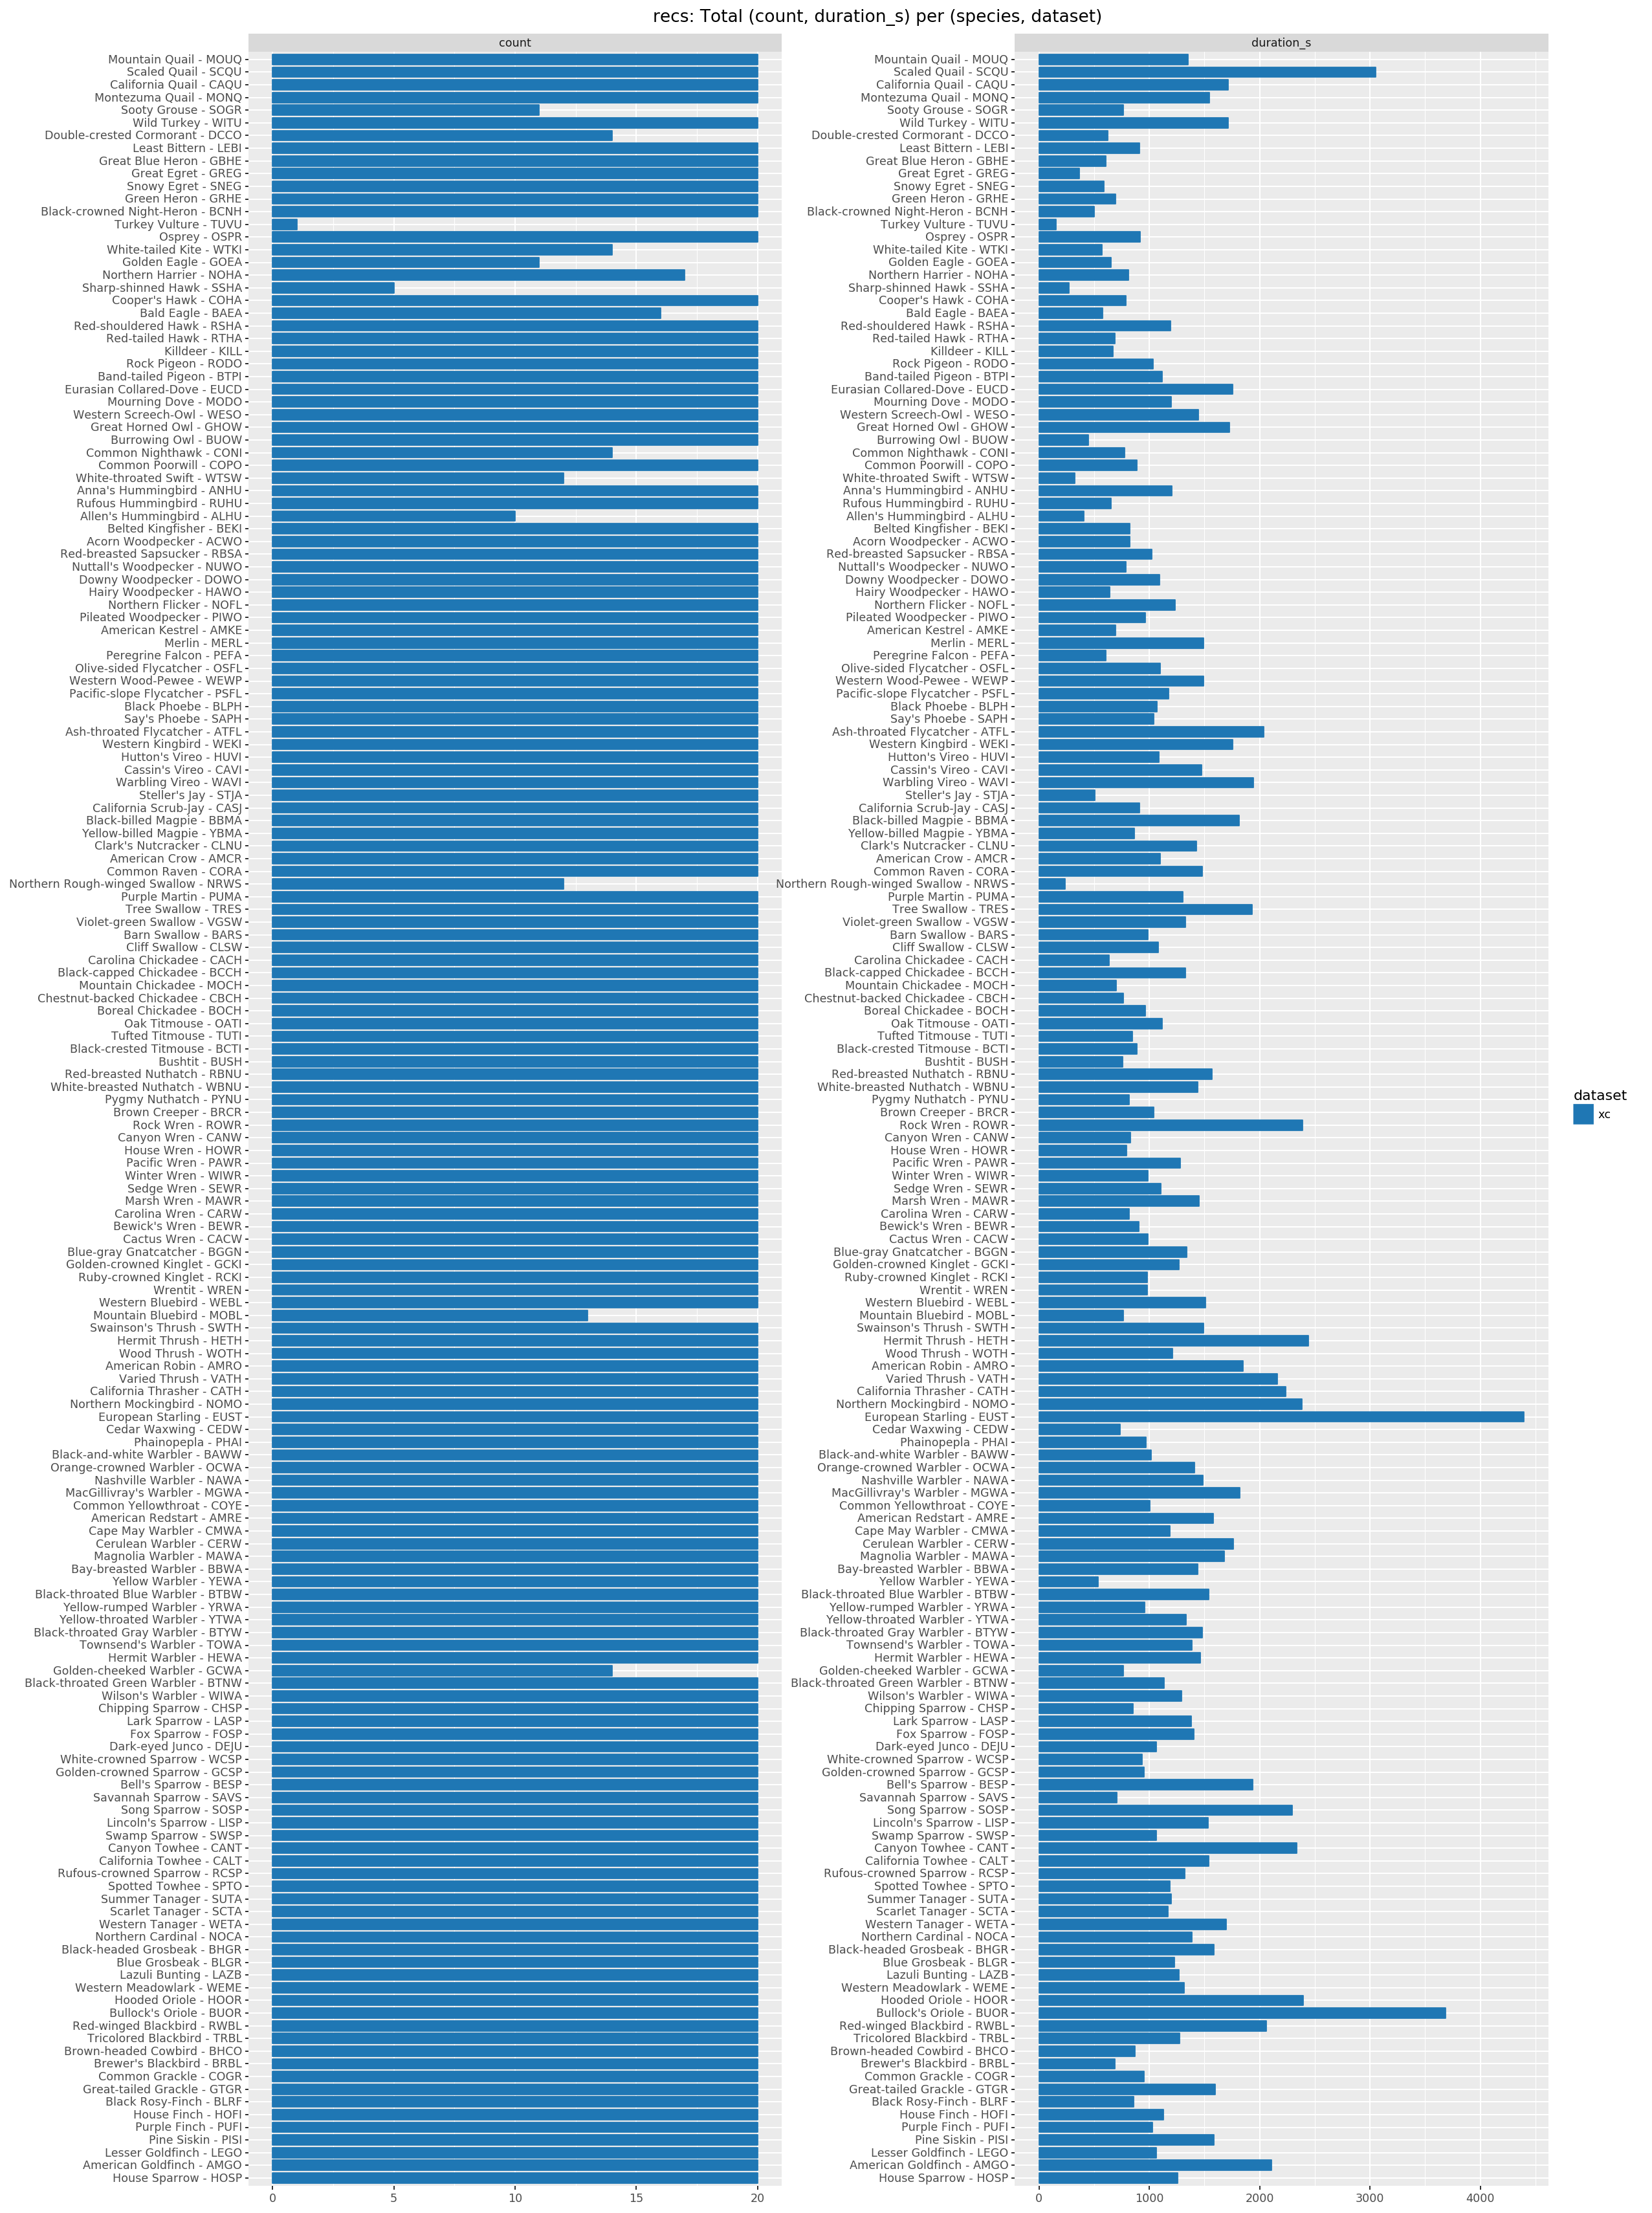

<ggplot: (306223529)>

In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_reverse_cat, 'species')
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

In [ ]:
# Load a saved projection model
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))


[16:20:38.244] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Add .feat
recs = projection.transform(recs)

•

In [ ]:
# GridSearchCV many models / model params
param_grid = dict(
    classifier=[

        # KNN
        #   - Bad for large k because we only have ~7-26 instances per class
        #   - Bad for small k because KNN
        # 'cls: knn, n_neighbors: 100',
        'cls: knn, n_neighbors: 50',
        'cls: knn, n_neighbors: 25',
        # 'cls: knn, n_neighbors: 15',
        'cls: knn, n_neighbors: 10',
        'cls: knn, n_neighbors: 5',
        'cls: knn, n_neighbors: 3',
        'cls: knn, n_neighbors: 1',

        # SVM(RBF)
        #   - [SBF16] Uses these
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1',
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10',  # [SBF16]
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100',  # Same as C:10 [why?]
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1000',  # Same as C:10 [why?]

        # RandomForest(entropy)
        #   - [SP14] uses entropy
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # [SP14]
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',

        # RandomForest(gini)
        #   - sk uses gini by default
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # [sk default]
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 600',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 800',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 1000',

    ]
    # TODO agg_funs
)

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    cv=sk.model_selection.ShuffleSplit(
        # n_splits=1,  # [for ~1/2 hit/miss: ~9m, ~10g disk cache]
        # n_splits=2,
        n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        test_i='i_test',
        test_y='y_test',
        test_classes='estimator.classes_',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
    ),
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # n_jobs=1,  # For %prun
    # n_jobs=8,
    n_jobs=16,
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


•

!

!

[16:20:39.247] INFO   _fit_and_score... split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:20:39.300] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:20:39.358] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

•

[16:20:39.444] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

!

!

[16:20:39.581] INFO   _fit_and_score... split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

!

[16:20:39.710] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


•

!

[16:20:39.805] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:20:39.878] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

[16:20:40.107] INFO   _fit_and_score... split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:20:40.136] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

!

•

!

[16:20:40.555] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

!

!

[16:20:40.673] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:20:40.738] INFO   _fit_and_score... split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:20:40.962] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

[16:20:41.123] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

[16:20:41.288] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

!

[16:22:17.243] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 5')]


[16:22:17.423] INFO   _fit_and_score. split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 5')]


[16:22:17.656] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 5')]


[16:22:17.780] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 5')]


[16:22:17.801] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 10')]


[16:22:18.018] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 10')]


[16:22:18.058] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 25')]


[16:22:18.183] INFO   _fit_and_score. split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 10')]


[16:22:18.483] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 50')]


[16:22:18.552] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 10')]


[16:22:18.692] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 50')]


[16:22:18.698] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 50')]


[16:22:18.805] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 25')]


[16:22:18.924] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 25')]


[16:22:19.042] INFO   _fit_and_score. split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 25')]


[16:22:19.053] INFO   _fit_and_score. split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 50')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


•

!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.67s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:22:36.618] INFO   _fit_and_score... split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:22:36.632] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.70s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:22:36.983] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:22:37.006] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


•

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

•

!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.70s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

!

[16:22:37.696] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:22:37.777] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


•

[16:22:38.013] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:22:38.548] INFO   _fit_and_score... split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  2.0min


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:22:38.754] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:22:38.848] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


•

[16:22:38.901] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

!

!

!

[16:22:39.283] INFO   _fit_and_score... split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:22:39.379] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:22:39.526] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

•

[16:22:39.675] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

!

!

[16:22:40.132] INFO   _fit_and_score... split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:22:58.325] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 1')]


[16:22:58.326] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 1')]


[16:22:58.588] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 1')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:23:12.108] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:23:12.172] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

[16:23:12.430] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

[16:23:45.224] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:23:45.276] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:23:45.482] INFO   _fit_and_score. split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:23:45.622] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


•

•

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.63s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

!

!

[16:23:59.205] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:23:59.231] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


•

[16:23:59.378] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

•

!

!

[16:24:00.105] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:27:04.792] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 50')]


[16:27:04.914] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 50')]


[16:27:05.274] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 50')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.20s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

!

[16:27:06.956] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:27:06.999] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


•

!

!

•

!

[16:27:08.000] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:28:31.799] INFO   _fit_and_score. split_i[1], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1')]


[16:28:32.747] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1')]


[16:28:32.922] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1')]


[16:28:33.034] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1')]


[16:28:34.353] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10')]


[16:28:34.560] INFO   _fit_and_score. split_i[1], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100')]


[16:28:34.635] INFO   _fit_and_score. split_i[1], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10')]


[16:28:34.972] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10')]


[16:28:35.190] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10')]


!

[16:28:48.039] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.58s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:28:49.147] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


•

•

!

!

!

[16:28:49.786] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:28:49.872] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:28:50.939] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


•

•

!

!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:28:51.515] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:28:51.693] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


[16:28:51.812] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

•

!

!

•

!

[16:28:52.663] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:29:07.582] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100')]


[16:29:07.982] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100')]


[16:29:08.144] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:29:20.221] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

•

!

[16:29:20.582] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


•

!

!

[16:29:21.254] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:30:16.984] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 100')]


[16:30:18.469] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 50')]


[16:30:19.391] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 50')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 2.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.24s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:30:20.367] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:30:20.706] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.29s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:30:21.142] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 50')]


•

•

!

[16:30:22.323] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:30:23.360] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:31:41.436] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 100')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:31:44.602] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:32:04.181] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 100')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 2.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


•

•

!

[16:32:08.051] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:32:11.171] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 100')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.96s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:32:14.273] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:33:27.631] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 100')]


[16:33:27.932] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 100')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.95s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:33:30.826] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


•

!

•

!

[16:33:31.696] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:34:49.191] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 200')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 3.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:34:54.403] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:35:43.804] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 200')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 3.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:35:49.332] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:35:54.240] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 200')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 3.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


•

!

[16:35:59.773] INFO   _fit_and_score... split_i[1], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:39:40.307] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 200')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 3.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

[16:39:45.575] INFO   _fit_and_score... split_i[2], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

[16:41:15.319] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 200')]


[16:41:16.294] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 400')]


[16:41:16.599] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 200')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 4.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 3.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:41:21.395] INFO   _fit_and_score... split_i[3], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

!

[16:41:22.456] INFO   _fit_and_score... split_i[4], estimator[Search(classifier='cls: knn, n_neighbors: 3')]


!

/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 8.66s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:41:27.052] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 400')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 7.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:42:26.257] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 400')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 7.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:47:19.711] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 600')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 9.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:47:35.099] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 600')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 7.63s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:48:12.539] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 600')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 7.43s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:50:44.992] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 400')]


[16:50:45.549] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 400')]


[16:50:46.068] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: entropy, n_estimators: 400')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 5.42s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 5.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 5.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:51:35.426] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 800')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 6.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:52:21.846] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 800')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 6.95s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:52:31.867] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 800')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 5.97s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:54:52.539] INFO   _fit_and_score. split_i[1], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 6.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:55:54.159] INFO   _fit_and_score. split_i[2], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 6.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:56:19.522] INFO   _fit_and_score. split_i[4], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 6.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[16:56:30.001] INFO   _fit_and_score. split_i[3], estimator[Search(classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000')]


/Users/danb/hack/bubo/features/cache.py:100: UserWarning: Persisting input arguments took 5.67s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return func_cached(cache_key, ignore)


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed: 36.0min finished


ValueError: could not broadcast input array from shape (649,167) into shape (649)

In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, classifier_type, fold, ...
cv_models = (cv_results_splits_df(cv.cv_results_)
    # .params
    .assign(
        # Slow yaml parsing, compute up front
        params_dict=lambda df: df.apply(axis=1, func=lambda row: {
            'classifier': yaml.safe_load('{%s}' % row.param_classifier),
            # TODO More param_*
        }),
        params=lambda df: (
            df.pop('param_classifier')
            # TODO More param_*
        ),
    )
    # Dims from params
    .assign(
        classifier_type=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
            '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
            x['cls']
        )),
    )
    # .eval
    .assign(test_evals=lambda df: np.vectorize(SearchEvals)(
        i=df.pop('test_i'),
        y=df.pop('test_y'),
        classes=df.pop('test_classes'),
        y_scores=df.pop('test_predict_proba'),
    ))
    # Reorder
    .pipe(df_reorder_cols, first=[
        'model_id', 'params', 'params_dict', 'classifier_type',
    ])
)
display(
    df_summary(cv_models).T,
    cv_models[:5],
)

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.apply(axis=1, func=lambda row: row.classifier_type + '/' + row.split),
    )
    .pipe(df_ordered_cat, params=lambda df: param_grid['classifier'])
    .pipe(ggplot, aes(x='params', y='score', color='group'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05)
    + geom_line(aes(group='group + str(fold)'), alpha=.2)
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    + coord_cartesian(ylim=(-35, 0))
    + ylab('score (-coverage_error)')
    + ggtitle('Train/test scores')
)

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(param_grid['classifier']))
print('  fold[*/%s]' % cv.cv.n_splits)

In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            classifier_type=row.classifier_type,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
)
display(
    df_summary(coverage_errors_all_all).T,
    coverage_errors_all_all[:10],
)

In [ ]:
# Facet by classifier_type, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # Sort species by median(coverage_error) (across all models)
    .pipe(df_ordered_cat, y_true=lambda df: (
        df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
    ))
    .pipe(ggplot, aes(x='y_true', y='coverage_error', color='params'))
    + facet_wrap('classifier_type')
    + geom_line(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme_figsize('square')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_grid['classifier']))
    .pipe(ggplot, aes(x='params', y='coverage_error', color='classifier_type'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

# Model diagnostics: one model, all folds

In [ ]:
params_i = 18
params = param_grid['classifier'][params_i]
print("param_grid['classifier']:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_grid['classifier'])))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(param_grid['classifier']), params))
print('  fold[*/%s]' % cv.cv.n_splits)

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_grid['classifier']))
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    + theme_figsize('inline')
    + ggtitle(rf'Coverage error over fold$\times$instance ({params})')
)

In [ ]:
(coverage_errors_one_all
    [:5]
)

In [ ]:
# TODO TODO Fix KeyError 'TUVU'
cv_models[lambda df: df.params == params].pipe(lambda df: df.iloc[0].test_evals.classes).size
recs.species.unique().shape
(recs.species.unique() == 'TUVU').sum()

In [ ]:
# One-model/all-folds confusion matrix
with figsize('full'):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            # classes=df.iloc[0].test_evals.classes,  # XXX Sometimes misses some classes
            classes=recs.species.unique(),  # TODO TODO Fix KeyError 'TUVU'
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            # raw=True, scale=10,  # Faster dev
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = param_grid['classifier'][params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("param_grid['classifier']:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_grid['classifier'])))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(param_grid['classifier']), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

In [ ]:
# TODO TODO What's worth recovering here, given the plots above?
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75), geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id})')
# )

In [ ]:
# One-model/one-fold confusion matrix
with figsize('full'):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        # raw=True, scale=10,  # Faster dev
    )